In [ ]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# List of parameter dictionaries to test
l = [
    {
        'n_estimators': 500,
        'learning_rate': 0.05,
        'max_depth': 10,
        'num_leaves': 50,
        'min_data_in_leaf': 30,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.9,
        'bagging_freq': 5,
        'lambda_l1': 0.05,
        'lambda_l2': 0.05,
        'random_state': 42,
        'verbosity': -1
    }
]

# Load the dataset
df = pd.read_csv('train.csv')

# Select only the soil_type columns
soil_columns = [col for col in df.columns if col.startswith('Soil_Type')]

# Count the number of 0's and 1's in each soil_type column
zero_one_counts = pd.DataFrame({
    'Zeros': (df[soil_columns] == 0).sum(),
    'Ones': (df[soil_columns] == 1).sum()
})


# Check for NaNs and fill if needed
df = df.fillna(0)  # Replace NaNs with 0, or use another method as appropriate

# Step 1: Apply log transformation to skewed columns, handling negative values by adding a constant
skewed_columns_1 = [
    'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology',
    'Horizontal_Distance_To_Roadways',
    'Horizontal_Distance_To_Fire_Points'
]
skewed_columns_2 = [    
    'Hillshade_3pm',
    "Hillshade_9am",
    "Hillshade_Noon"
    ]
sparse_columns = zero_one_counts[zero_one_counts['Ones'] < 55].index
df = df.drop(columns=sparse_columns)



# Separating the target column 'Cover_Type' from the features
X = df.drop(columns=['Cover_Type'])  # Drop target and non-feature columns
y = df['Cover_Type']  # Target column

# Normalize the numerical features
scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

# List of numerical columns to be scaled
numerical_columns = [
    'Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
    'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
    'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 
    'Horizontal_Distance_To_Fire_Points'
]

log_numerical_columns = [
    'Elevation', 'Aspect', 'Slope', 'log_Horizontal_Distance_To_Hydrology',
    'log_Vertical_Distance_To_Hydrology', 'log_Horizontal_Distance_To_Roadways',
    'log_Hillshade_9am', 'log_Hillshade_Noon', 'log_Hillshade_3pm', 
    'log_Horizontal_Distance_To_Fire_Points'
]
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[numerical_columns] = minmax_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = minmax_scaler.transform(X_test[numerical_columns])

min_values = {}
shifts = {}
best_shift_1 = 5
best_shift_2 = 5 

for col in skewed_columns_1:
    min_values[col] = X_train[col].min()
    shifts[col] = best_shift_1 - min_values[col] if min_values[col] <= 0 else 0
    X_train[f'log_{col}'] = np.log(X_train[col] + shifts[col] + 1 )
for col in skewed_columns_2:
    min_values[col] = X_train[col].min()
    X_train[f'log_{col}'] = (X_train[col].max()- X_train[col] + best_shift_2 )**0.2
X_train = X_train.drop(columns=skewed_columns_1 +  skewed_columns_2)


for col in skewed_columns_1:
    X_test[f'log_{col}'] = np.log(X_test[col] + shifts[col] + 1 )
for col in skewed_columns_2:
    X_test[f'log_{col}'] = np.log(X_test[col].max()- X_test[col] + best_shift_2 )**0.2
    
X_test = X_test.drop(columns=skewed_columns_1 +  skewed_columns_2)

X_train[log_numerical_columns] = scaler.fit_transform(X_train[log_numerical_columns])
X_test[log_numerical_columns] = scaler.transform(X_test[log_numerical_columns])

n_with_outliers = len(y_train)
for col in log_numerical_columns: 
    # Compute Z-fold for the column
    X_train['Z_fold'] = (X_train[col] - X_train[col].mean()) / X_train[col].std()

    # Get the indices of rows where Z-score is within [-3, 3]
    valid_indices = X_train[(X_train['Z_fold'] < 3) & (X_train['Z_fold'] > -3)].index

    # Filter both X_train and y_train using these indices
    X_train = X_train.loc[valid_indices]
    y_train = y_train.loc[valid_indices]


print(f'The proportion of outliers is {1-len(y_train)/n_with_outliers}')
# Drop the temporary Z-fold column
X_train = X_train.drop(columns=['Z_fold'])


# Initialize the LGBMClassifier with the current parameters
lgbm_model = LGBMClassifier(**l[0])

# Train the model
lgbm_model.fit(X_train, y_train)

# Make predictions
y_pred = lgbm_model.predict(X_test)
y_pred_train = lgbm_model.predict(X_train)
# Evaluate the model's performance
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


The proportion of outliers is 0.07738095238095233


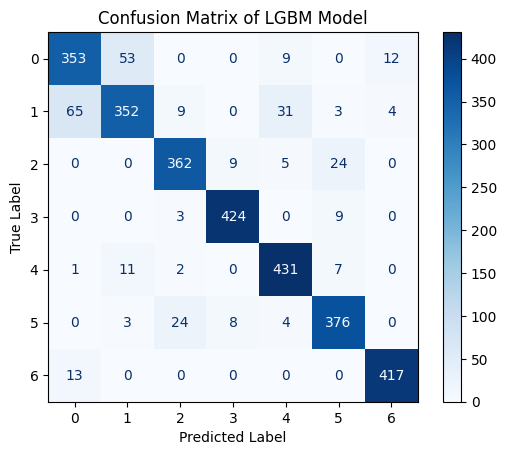

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')  # Use a color map for clarity
plt.title("Confusion Matrix of LGBM Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [42]:
# Initialize the LGBMClassifier with the current parameters
lgbm_model = LGBMClassifier(**l[0])
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)
# Train the model
lgbm_model.fit(X_combined, y_combined)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=5, feature_fraction=0.7,
               lambda_l1=0.05, lambda_l2=0.05, learning_rate=0.05, max_depth=10,
               min_data_in_leaf=30, n_estimators=500, num_leaves=50,
               random_state=42, verbosity=-1)

In [44]:
df_subs = pd.read_csv('test-full.csv')
df_subs = df_subs.drop(columns=sparse_columns)
df_subs[numerical_columns] = minmax_scaler.transform(df_subs[numerical_columns])

for col in skewed_columns_1:
    df_subs[f'log_{col}'] = np.log(df_subs[col] + shifts[col] + 1)
for col in skewed_columns_2:
    df_subs[f'log_{col}'] = (df_subs[col].max() - df_subs[col] + best_shift_2)**0.2

df_subs = df_subs.drop(columns=skewed_columns_1 + skewed_columns_2)

df_subs[log_numerical_columns] = scaler.transform(df_subs[log_numerical_columns])

In [46]:
submission_preds = pd.DataFrame(lgbm_model.predict(df_subs), columns=['Cover_Type'])

In [47]:
df.to_csv('filename.csv', index=False)

In [48]:
submission_preds.to_csv('submission.csv', index=True)

In [49]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('submission.csv')

# Increment the 'Id' column by 1
df['Id'] = df['Id'] + 1

# Save the modified DataFrame back to CSV
df.to_csv('submission1.csv', index=False)
